# Homework 11

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date:** Saturday, December 1st, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

**Michelle (Chia Chi) Ho, Jiejun Lu, Jiawen Tong**

<div class="answer-separator">
------------------------
</div>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.special import erf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import seaborn as sns
from IPython.display import display

from theano import shared
import theano.tensor as tt
import pymc3 as pm
from pymc3 import Model
from pymc3.math import invlogit

%matplotlib inline
sns.set_style('whitegrid')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Question 1: Crazy Rich Bayesians Don't Need No Educations?

**coding required**

In this problem, you will explore how to recast data, tasks and research questions from a variety of different contexts so that an existing model can be applied for analysis.

Example 10.1.3 in ["Statistical Rethinking"](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjopa0chtr7ns%2FStatistical_Rethinking_excerpt.pdf), the excerpt of which is included with this assignment, illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

In this problem, you are given data from the [1994 U.S. Census](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9zvsjoscq%2Fcensus_data.csv). The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). You will be investigate the effect of gender on a person's yearly income in the dataset. In particular, we want to know how a person's gender effect the likelihood of their yearly salary being above or below \$50k. 

1.1. Read the dataset into a dataframe and aggregate the dataset by organizing the  dataframe into seven different categories. 

The categories we wish to consider are: 
* 4 year college degree
* Some-college or two year academic college degree
* High school
* Professional, vocational school
* Masters 
* Doctorate
* Some or no high school

Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) the crazy rich income of $50k (see the dataset in Example 10.1.3). 

1.2. Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 

1.3. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. 

1.4. Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. One of the models should take into account education only the other should take into account gender and education on income.

1.5. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data.

1.6. Using your analysis from 1.3, discuss the effect gender has on income.

1.7. Using your analysis from 1.5, discuss the effect of gender on income taking into account an individual's education.

(**Hint: If you haven't seen WAIC, it's because we'll be covering it on Monday November 26, 2018.  In the meantime checkout info about WAIC in this resource on [PyMC3 model selection](https://docs.pymc.io/notebooks/model_comparison.html).**)

**Gratuitous Titular Reference**:  

If you haven't watched [Crazy Rich Asians](http://www.crazyrichasiansmovie.com/) then it might be time.

If you haven't listened to [Pink Floyd's](https://en.wikipedia.org/wiki/Pink_Floyd) [The Wall](https://en.wikipedia.org/wiki/The_Wall) then it might be time.

Also who are you? :-)

Anyway [You don't need no thought control](https://www.youtube.com/watch?v=YR5ApYxkU-U), [You probably want us teaching staff to leave you kids alone](https://www.youtube.com/watch?v=YR5ApYxkU-U), and [Education is overrated, right?  You don't need it!](https://www.youtube.com/watch?v=YR5ApYxkU-U)

In [2]:
# 1.1 load census data
df_census = pd.read_csv('census_data.csv', index_col=0)
print('total # observations:', df_census.shape[0])
display(df_census.head())

# 4 year college degree : 4
# Some-college or two year academic college degree : 2
# High school : 1
# Professional, vocational school : 3
# Masters : 5
# Doctorate : 6
# Some or no high school: 0
edu_map = {
    'Bachelors': 4,
    'HS-grad': 1,
    '11th': 0,
    'Masters': 5,
    '9th': 0,
    'Some-college': 2,
    'Assoc-acdm': 2, 
    'Assoc-voc': 3, 
    '7th-8th': 0,
    'Doctorate': 6,
    'Prof-school': 3,
    '5th-6th': 0, 
    '10th': 0,
    '1st-4th': 0,
    'Preschool': 0, 
    '12th': 0
}
earning_map = {
    '<=50K': 0,
    '>50K': 1
}

df_census['edu'] = df_census['edu'].apply(lambda x: edu_map[x]) # re-aggregate education level
df_census['earning'] = df_census['earning'].apply(lambda x: earning_map[x]) # encode earning level
df_census.head()

total # observations: 32561


,age,sector,edu,marital,race,sex,earning
0,39,State-gov,Bachelors,Never-married,White,Male,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,White,Male,<=50K
2,38,Private,HS-grad,Divorced,White,Male,<=50K
3,53,Private,11th,Married-civ-spouse,Black,Male,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Black,Female,<=50K


,age,sector,edu,marital,race,sex,earning
0,39,State-gov,4,Never-married,White,Male,0
1,50,Self-emp-not-inc,4,Married-civ-spouse,White,Male,0
2,38,Private,1,Divorced,White,Male,0
3,53,Private,0,Married-civ-spouse,Black,Male,0
4,28,Private,4,Married-civ-spouse,Black,Female,0


In [3]:
# groupby ['edu', 'sex'], aggregate count of earning >50K records
df_agg = df_census.groupby(['edu', 'sex'])['earning'].agg([len, sum]).rename(columns={'len':'N', 'sum':'count'})
df_agg['p'] = df_agg['count'] / df_agg['N']
df_agg

N  count         p
edu sex                          
0   Female  1321     23  0.017411
    Male    2932    221  0.075375
1   Female  3390    226  0.066667
    Male    7111   1449  0.203769
2   Female  3227    253  0.078401
    Male    5131   1399  0.272656
3   Female   592    109  0.184122
    Male    1366    675  0.494143
4   Female  1619    339  0.209389
    Male    3736   1882  0.503747
5   Female   536    179  0.333955
    Male    1187    780  0.657119
6   Female    86     50  0.581395
    Male     327    256  0.782875

In [4]:
# index the aggregated df by 'edu' or 'sex'
df_edu = df_agg.reset_index(level='sex')
df_sex = df_agg.reset_index(level='edu')
display(df_edu.head()), display(df_sex.head())

,sex,N,count,p
edu,,,,
0,Female,1321,23,0.017411
0,Male,2932,221,0.075375
1,Female,3390,226,0.066667
1,Male,7111,1449,0.203769
2,Female,3227,253,0.078401


,edu,N,count,p
sex,,,,
Female,0,1321,23,0.017411
Male,0,2932,221,0.075375
Female,1,3390,226,0.066667
Male,1,7111,1449,0.203769
Female,2,3227,253,0.078401


(None, None)

In [5]:
# 1.2 model - no gender
with Model() as model_a:
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=1)
    p = pm.Deterministic('p', invlogit(alpha))
    c = pm.Binomial('c', n=df_agg['N'].values, p=p, observed=df_agg['count'].values)
    tr_a = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:09<00:00, 1512.57draws/s]


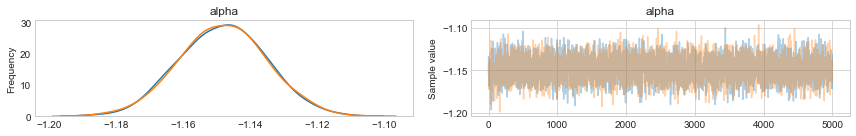

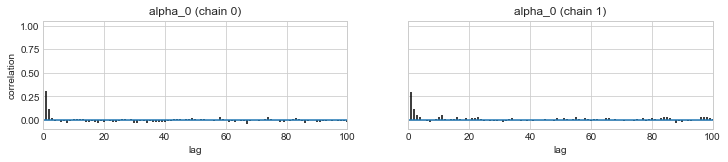

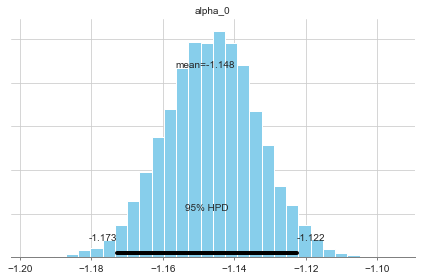

In [6]:
pm.traceplot(tr_a, varnames=['alpha'])
pm.autocorrplot(tr_a, varnames=['alpha'])
pm.plot_posterior(tr_a, varnames=['alpha'])
plt.tight_layout()

In [7]:
# 1.2 model - with gender
with Model() as model_b:
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=1)
    p = pm.Deterministic('p', invlogit(alpha + beta*(df_edu['sex']=='Male').astype(int)))
    c = pm.Binomial('c', n=df_agg['N'].values, p=p, observed=df_agg['count'].values)
    tr_b = pm.sample(5000, tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 18000/18000 [00:18<00:00, 990.20draws/s] 
The acceptance probability does not match the target. It is 0.8982562529831711, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5899170986571037, but should be close to 0.8. Try to increase the number of tuning steps.


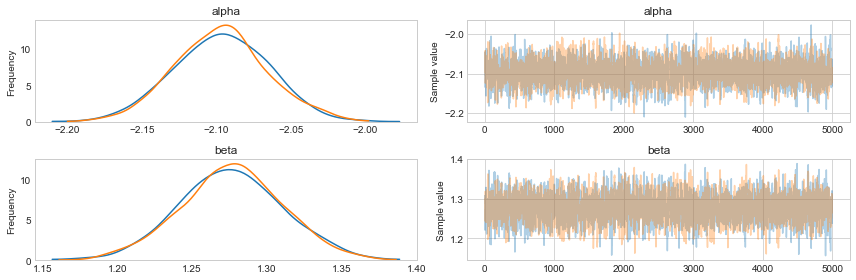

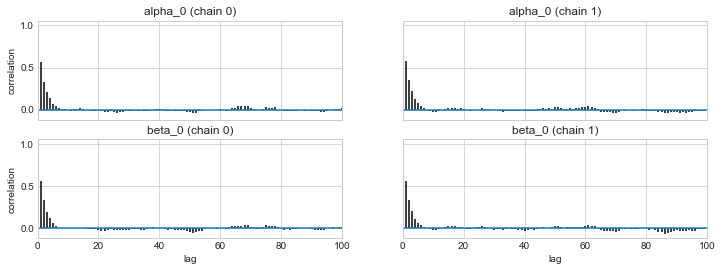

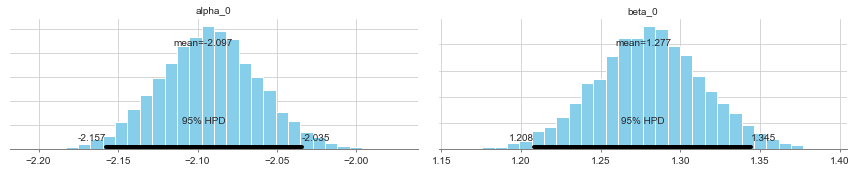

In [8]:
pm.traceplot(tr_b, varnames=['alpha', 'beta'])
pm.autocorrplot(tr_b, varnames=['alpha', 'beta'])
pm.plot_posterior(tr_b, varnames=['alpha', 'beta'])
plt.tight_layout()

In [15]:
# 1.3 model comparison
df_compare_ab = pm.compare({model_a: tr_a, model_b: tr_b}, method='pseudo-BMA')
df_compare_ab['name'] = ['gender', 'no_gender']
df_compare_ab.set_index('name')

/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
name,,,,,,,
gender,4656.4,500.3,0,1,1181.7,0,1
no_gender,6181.6,405.1,1525.19,0,1583.26,1375.94,1


In [13]:
# posterior predictive samples: pp_count
pp_count_a = pm.sample_ppc(tr_a, model=model_a, samples=10000)['c']
pp_count_b = pm.sample_ppc(tr_b, model=model_b, samples=10000)['c']

# p from posterior predictive samples = pp_count / N
pct_pp_a = pp_count_a / np.tile(df_agg['N'], [10000, 1])
pct_pp_b = pp_count_b / np.tile(df_agg['N'], [10000, 1])

# 89% CI of pp_count / N
pct_ppCI_a = np.percentile(pct_pp_a, [5.5, 94.5], axis=0)
pct_ppCI_b = np.percentile(pct_pp_b, [5.5, 94.5], axis=0)

# 89% CI of p from posterior draws
p_postCI_a = np.percentile(tr_a['p'].flatten(), [5.5, 94.5])
p_postCI_b = np.percentile(tr_b['p'], [5.5, 94.5], axis=0)

100%|██████████| 10000/10000 [00:07<00:00, 1406.74it/s]


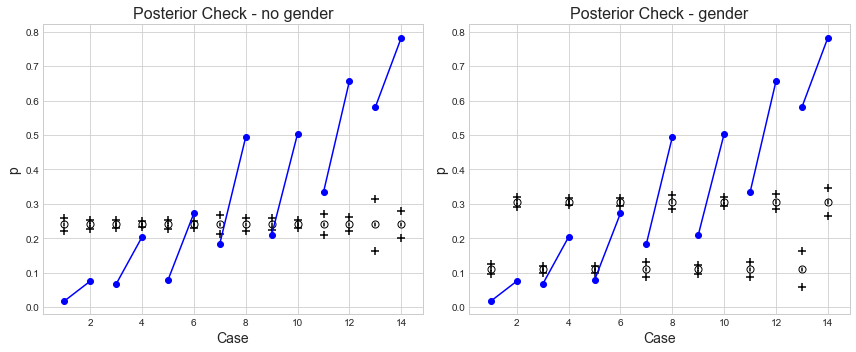

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(0, len(df_agg), 2):
    # p from data 
    ax[0].plot([i+1, i+2], df_agg.iloc[[i, i+1]]['p'], '-bo')
    ax[1].plot([i+1, i+2], df_agg.iloc[[i, i+1]]['p'], '-bo')

for i in range(len(df_agg)):
    # p from posterior mean
    ax[0].scatter([i+1], tr_a['p'].flatten().mean(), marker='o', c='w', edgecolors='k', s=50, label='data')
    ax[1].scatter([i+1], tr_b['p'].mean(axis=0)[i], marker='o', c='w', edgecolors='k', s=50, label='data')
    
    # 89% CI of p from posterior draws
    ax[0].plot([i+1, i+1], p_postCI_a, c='k')
    ax[1].plot([i+1, i+1], p_postCI_b[:, i], c='k')
    
    # 89% CI of p from pp_count / N
    ax[0].scatter([i+1, i+1], pct_ppCI_a[:, i], marker='+', c='k', s=50)
    ax[1].scatter([i+1, i+1], pct_ppCI_b[:, i], marker='+', c='k', s=50)

ax[0].set_title('Posterior Check - no gender', fontsize=16)
ax[1].set_title('Posterior Check - gender', fontsize=16)
ax[0].set_xlabel('Case', fontsize=14)
ax[1].set_xlabel('Case', fontsize=14)
ax[0].set_ylabel('p', fontsize=14)
ax[1].set_ylabel('p', fontsize=14)
plt.tight_layout()

In [16]:
# 1.4 model - with edu only
with Model() as model_c:
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=7)
    p = pm.Deterministic('p', invlogit(alpha[df_sex['edu'].values]))
    c = pm.Binomial('c', n=df_agg['N'].values, p=p, observed=df_agg['count'].values)
    tr_c = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:14<00:00, 984.53draws/s] 


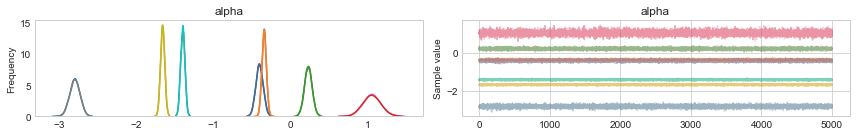

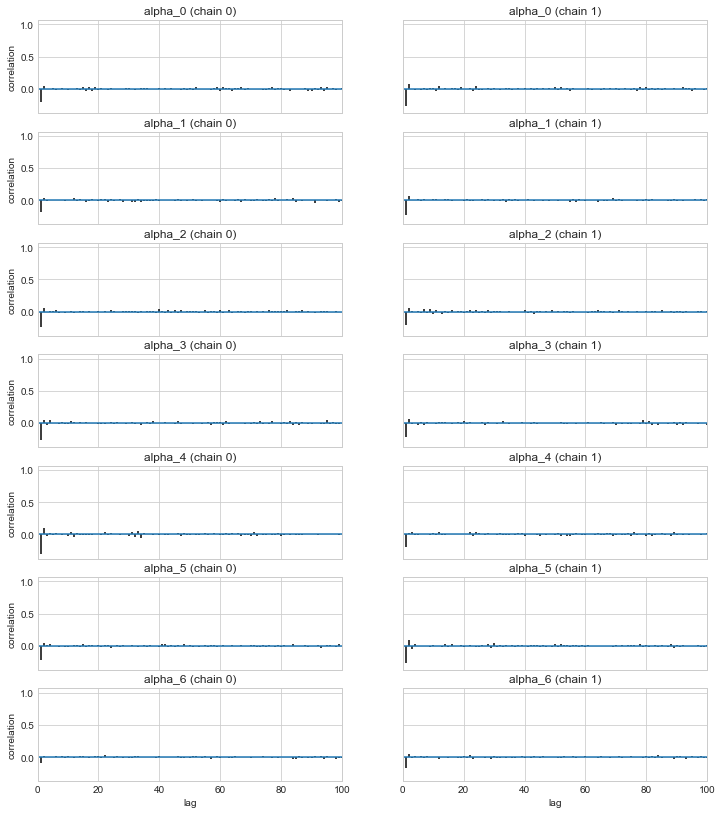

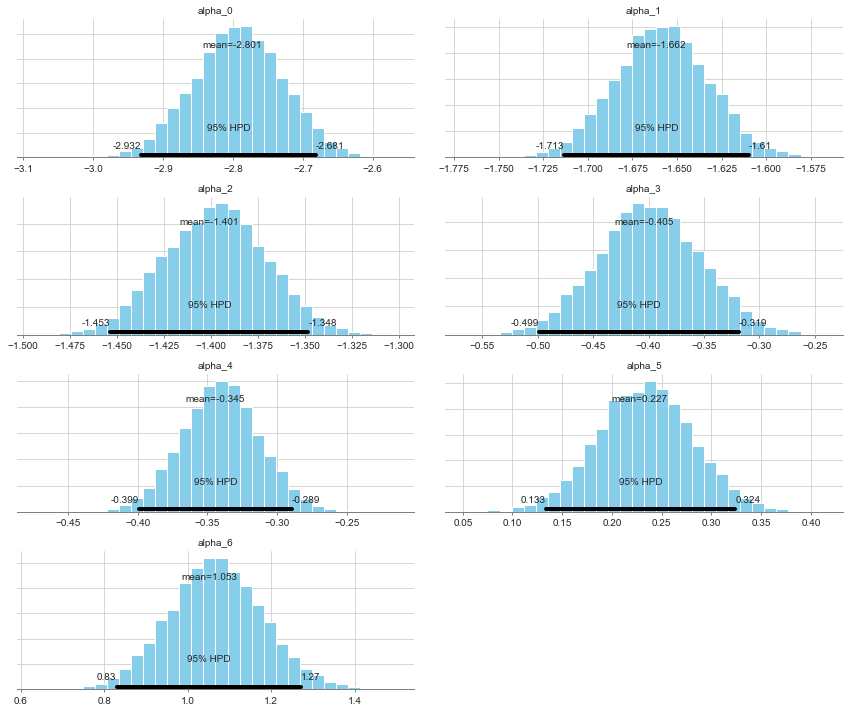

In [17]:
pm.traceplot(tr_c, varnames=['alpha'])
pm.autocorrplot(tr_c, varnames=['alpha'])
pm.plot_posterior(tr_c, varnames=['alpha'])
plt.tight_layout()

In [18]:
# 1.4 model - with edu & gender
with Model() as model_d:
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=7)
    beta = pm.Normal('beta', mu=0, sd=10, shape=1)
    p = pm.Deterministic('p', invlogit(alpha[df_sex['edu']] + beta*(df_edu['sex']=='Male').astype(int)))
    c = pm.Binomial('c', n=df_agg['N'].values, p=p, observed=df_agg['count'].values)
    tr_d = pm.sample(5000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 16000/16000 [00:24<00:00, 660.62draws/s]


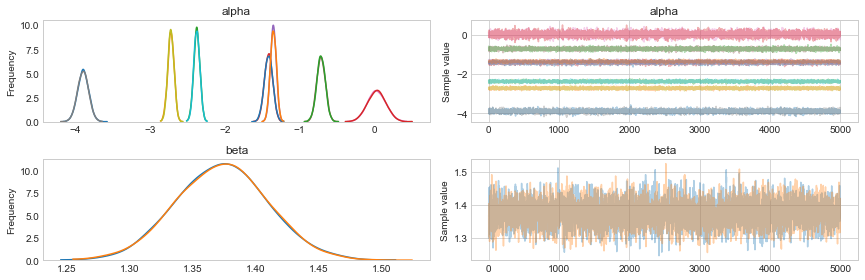

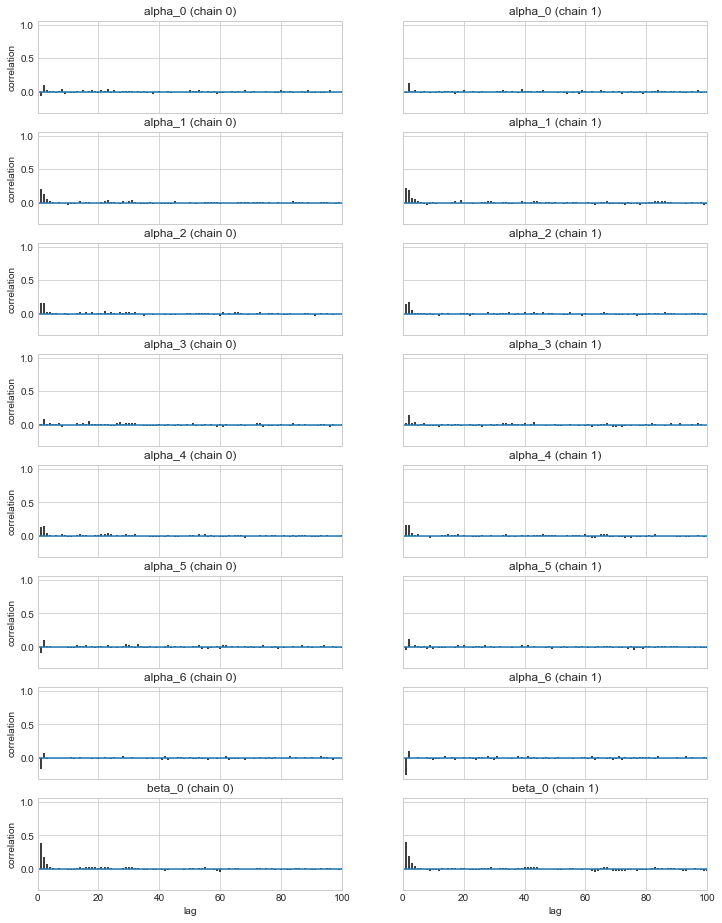

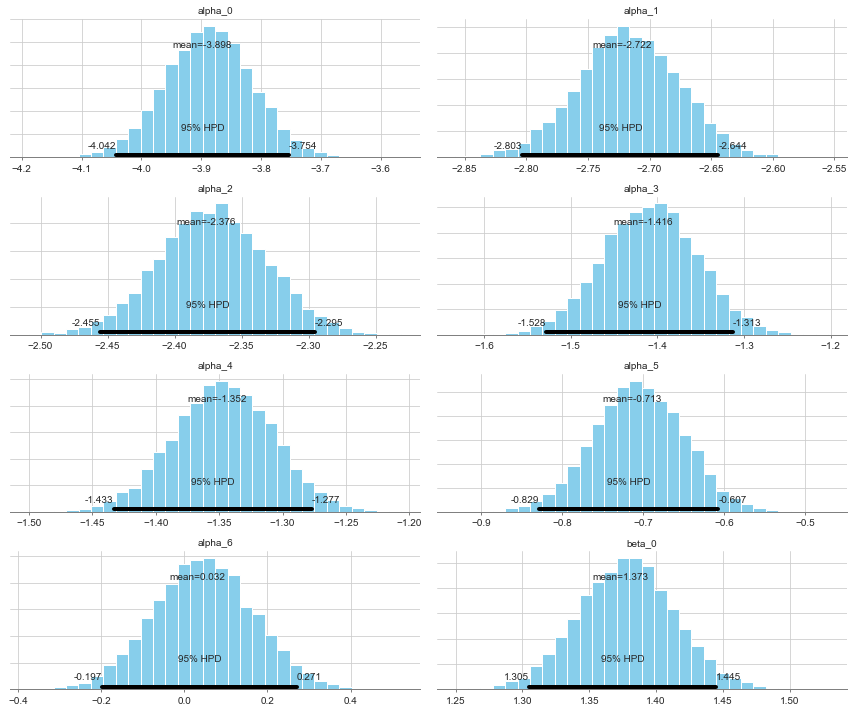

In [19]:
pm.traceplot(tr_d, varnames=['alpha', 'beta'])
pm.autocorrplot(tr_d, varnames=['alpha', 'beta'])
pm.plot_posterior(tr_d, varnames=['alpha', 'beta'])
plt.tight_layout()

In [20]:
# 1.5 model comparison
df_compare_cd = pm.compare({model_c: tr_c, model_d: tr_d}, method='pseudo-BMA')
df_compare_cd['name'] = ['edu_gender', 'edu']
df_compare_cd.set_index('name')

/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
name,,,,,,,
edu_gender,123.4,6.22,0,1,5.68,0,1
edu,2838.3,700.9,2714.9,0,584.84,581.8,1


In [21]:
# posterior predictive samples: pp_count
pp_count_c = pm.sample_ppc(tr_c, model=model_c, samples=10000)['c']
pp_count_d = pm.sample_ppc(tr_d, model=model_d, samples=10000)['c']

# p from posterior predictive samples = pp_count / N
pct_pp_c = pp_count_c / np.tile(df_agg['N'], [10000, 1])
pct_pp_d = pp_count_d / np.tile(df_agg['N'], [10000, 1])

# 89% CI of pp_count / N
pct_ppCI_c = np.percentile(pct_pp_c, [5.5, 94.5], axis=0)
pct_ppCI_d = np.percentile(pct_pp_d, [5.5, 94.5], axis=0)

# 89% CI of p from posterior draws
p_postCI_c = np.percentile(tr_c['p'], [5.5, 94.5], axis=0)
p_postCI_d = np.percentile(tr_d['p'], [5.5, 94.5], axis=0)

100%|██████████| 10000/10000 [00:11<00:00, 852.96it/s]


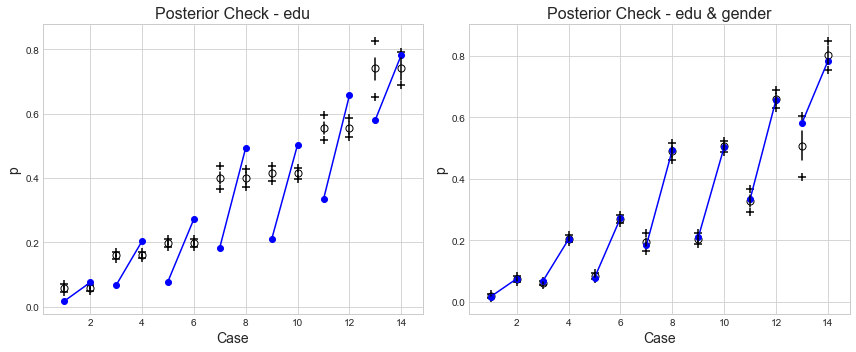

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(0, len(df_agg), 2):
    # p from data 
    ax[0].plot([i+1, i+2], df_agg.iloc[[i, i+1]]['p'], '-bo')
    ax[1].plot([i+1, i+2], df_agg.iloc[[i, i+1]]['p'], '-bo')

for i in range(len(df_agg)):
    # p from posterior mean
    ax[0].scatter([i+1], tr_c['p'].mean(axis=0)[i], marker='o', c='w', edgecolors='k', s=50, label='data')
    ax[1].scatter([i+1], tr_d['p'].mean(axis=0)[i], marker='o', c='w', edgecolors='k', s=50, label='data')
    
    # 89% CI of p from posterior draws
    ax[0].plot([i+1, i+1], p_postCI_c[:, i], c='k')
    ax[1].plot([i+1, i+1], p_postCI_d[:, i], c='k')
    
    # 89% CI of p from pp_count / N
    ax[0].scatter([i+1, i+1], pct_ppCI_c[:, i], marker='+', c='k', s=50)
    ax[1].scatter([i+1, i+1], pct_ppCI_d[:, i], marker='+', c='k', s=50)

ax[0].set_title('Posterior Check - edu', fontsize=16)
ax[1].set_title('Posterior Check - edu & gender', fontsize=16)
ax[0].set_xlabel('Case', fontsize=14)
ax[1].set_xlabel('Case', fontsize=14)
ax[0].set_ylabel('p', fontsize=14)
ax[1].set_ylabel('p', fontsize=14)
plt.tight_layout()

### Answer 1.6 
**Using your analysis from 1.3, discuss the effect gender has on income.**

- Based on wAIC scores, the model considering gender differences better fits the data than the model that did not .
- Based on the posterior check of `p(earning > 50K)` plots, the model considering gender differences gave posteriors (o) and posterior predictive samples (+) closer to the observed data points (blue dots).


### Answer 1.7
**Using your analysis from 1.5, discuss the effect of gender on income taking into account an individual's education.**

- Based on wAIC scores, the models considering educational differences are in general better than the first 2 models that did not. Among all, the model considering both gender and educational differences showed the best performance.
- Based on the posterior check of `p(earning > 50K)` plots, the model considering both gender and educational differences gave the closest posteriors (o) and posterior predictive samples (+) to the observed data points (blue dots) among all 4 models. 

<div class="answer-separator">
------------------------
</div>

## Question 2:  My Sister-In-Law's Baby Cousin Tracy ...

**coding required**

Wikipedia describes the National Annenberg Election Survey as follows -- "National Annenberg Election Survey (NAES) is the largest academic public opinion survey conducted during the American presidential elections. It is conducted by the Annenberg Public Policy Center at the University of Pennsylvania."  In the file [survey.csv](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9sr9dh4g5%2Fsurvey.csv) we provide the following data from the 2004 National Annenberg Election Survey:  `age` -- the age of the respondents, `numr` -- the number of responses, and `knowlgbtq` -- the number of people at the given age who have at least one LGBTQ acquaintance.  We want you to model how age influences likelihood of interaction with members of the LGBTQ community in three ways. 


2.1. Using pymc3, create a bayesian linear regression model  with `age` as the quantitative predictor and `knowlgbtq` as the response variable. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

2.2. Using pymc3, create a 1-D Gaussian Process regression model with the same feature and dependent variables.  Use a squared exponential covariance function. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

(**Hint: For an example of GP Regression from class see [this GP Recap](http://am207.info/wiki/gpsalmon.html)**)

2.3. How do the models compare? Does age influence likelihood of acquaintance with someone LGBTQ? For Bayesian Linear Regression and GP Regression, how does age affect the variance of the estimates?


**Gratuitous Titular References**:  

Massachusett's own [Joiner Lucas](https://en.wikipedia.org/wiki/Joyner_Lucas) blew up in November 2017 with the release of his single ["I'm Not Racist"](https://www.youtube.com/watch?v=43gm3CJePn0) on Youtube.  The video quickly went viral. The title comes from the song's lyrics (and references that degrees of separation that can be involved in individual experience with members of any under-represented group).

Given the oncoming cold spell [Winter Blues](https://www.youtube.com/watch?v=I7_ofdl9Wfs) another popular track may be relevant.

### Note:
We chose to use `p = knowlgbtq / numr` instead of `knowlgbtq` as the response as this question aims to model the dependency between age and the **likelihood of acquaintance** with someone LGBTQ, and therefore this count value should be normalized by `numr`. 

In [2]:
df_survey = pd.read_csv('survey.csv')
df_survey['p'] = df_survey['knowlgbtq'] / df_survey['numr']
df_survey['age_c'] = df_survey['age'] - df_survey['age'].mean()
df_survey.head()

,age,numr,knowlgbtq,p,age_c
0,18,310,158,0.509677,-38.589744
1,19,221,118,0.533937,-37.589744
2,20,217,120,0.552995,-36.589744
3,21,255,131,0.513725,-35.589744
4,22,301,168,0.558140,-34.589744


In [3]:
# 2.1 bayesian linear regression
age_shared_c = shared(df_survey['age_c'].values)
with Model() as lin_reg:
    # model parameters
    alpha = pm.Normal('alpha', mu=df_survey['p'].mean(), sd=100, shape=1)
    beta = pm.Normal('beta', mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=500)
    
    # deterministic
    mu = pm.Deterministic('mu', alpha+beta*age_shared_c)
    
    # data likelihood
    Y = pm.Normal('Y', mu=mu, sd=sigma, observed=df_survey['p'])
    
    # posterior samples
    tr_lin_reg = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 20000/20000 [00:16<00:00, 1218.27draws/s]


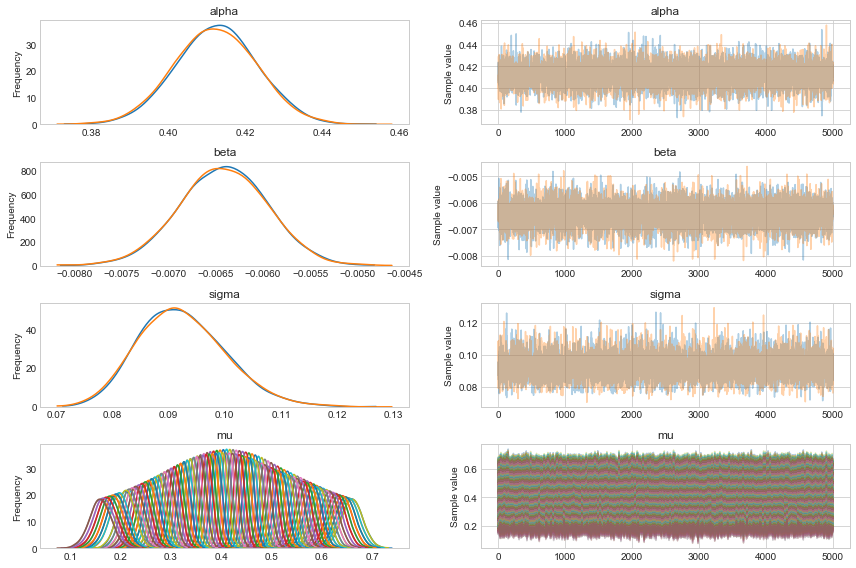

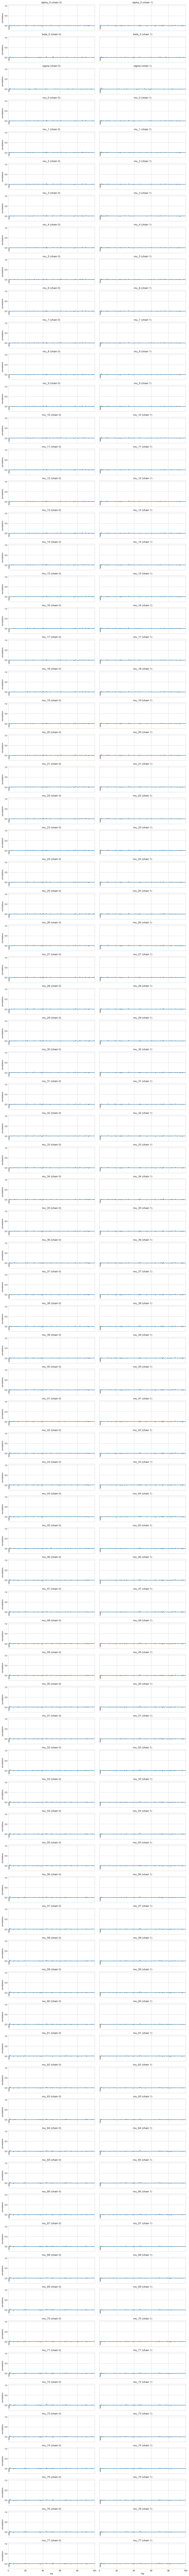

In [4]:
# plot trace, correlation
pm.traceplot(tr_lin_reg)
pm.autocorrplot(tr_lin_reg)
plt.tight_layout()

In [5]:
pm.gelman_rubin(tr_lin_reg)

{'alpha': array([1.00041602]),
 'beta': array([0.99995533]),
 'mu': array([0.99992572, 0.99992851, 0.99993155, 0.99993486, 0.99993847,
        0.99994241, 0.99994669, 0.99995136, 0.99995644, 0.99996196,
        0.99996796, 0.99997447, 0.99998155, 0.99998922, 0.99999753,
        1.00000653, 1.00001626, 1.00002676, 1.00003807, 1.00005025,
        1.00006331, 1.0000773 , 1.00009224, 1.00010813, 1.00012498,
        1.00014277, 1.00016146, 1.00018098, 1.00020126, 1.00022217,
        1.00024357, 1.00026529, 1.00028713, 1.00030884, 1.00033019,
        1.00035091, 1.00037073, 1.00038938, 1.00040661, 1.00042221,
        1.00043598, 1.00044778, 1.00045751, 1.00046512, 1.00047061,
        1.00047403, 1.00047547, 1.00047505, 1.00047291, 1.00046922,
        1.00046416, 1.0004579 , 1.00045061, 1.00044248, 1.00043366,
        1.00042429, 1.00041451, 1.00040443, 1.00039416, 1.0003838 ,
        1.00037341, 1.00036306, 1.00035281, 1.0003427 , 1.00033277,
        1.00032304, 1.00031353, 1.00030427, 1.000

In [6]:
# test predictors
age_test = np.linspace(0, 100, 101).astype(int)

# age demean
age_shared_c.set_value(age_test - age_test.mean())

# prediction using parameters posteriors
y_post = tr_lin_reg['alpha'].reshape(-1, 1) + tr_lin_reg['beta'].reshape(-1, 1) * age_shared_c

# posterior predictives samples
y_pp = pm.sample_ppc(tr_lin_reg, model=lin_reg, samples=10000)['Y']

100%|██████████| 10000/10000 [00:13<00:00, 609.71it/s]


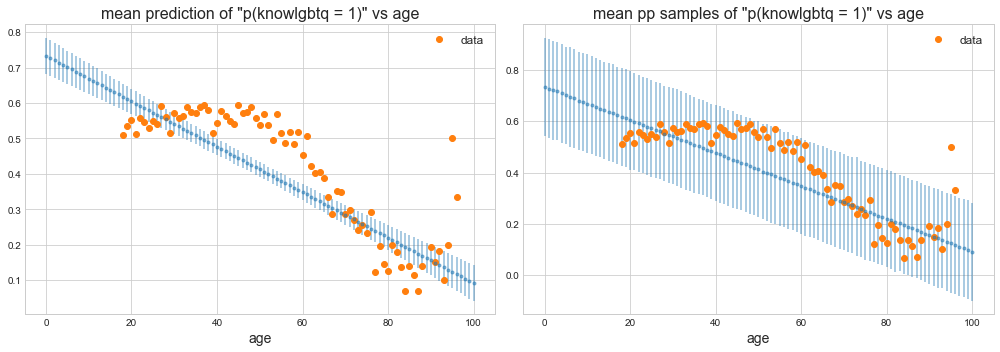

In [7]:
# plot mean prediction on age from [0, 100]
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].errorbar(x=age_test, y=y_post.mean(axis=0).eval(), yerr=2*y_post.std(axis=0).eval(), 
               linestyle='', marker='.', alpha=0.5)
ax[1].errorbar(x=age_test, y=y_pp.mean(axis=0), yerr=2*y_pp.std(axis=0), 
               linestyle='', marker='.', alpha=0.5)
ax[0].plot(df_survey['age'], df_survey['p'], 'o', label='data')
ax[1].plot(df_survey['age'], df_survey['p'], 'o', label='data')
ax[0].set_xlabel('age', fontsize=14)
ax[1].set_xlabel('age', fontsize=14)
ax[0].set_title('mean prediction of "p(knowlgbtq = 1)" vs age', fontsize=16)
ax[1].set_title('mean pp samples of "p(knowlgbtq = 1)" vs age', fontsize=16)
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
plt.tight_layout()

In [8]:
# 2.2 GP
# taken from fonnesbeck
with pm.Model() as gp:

    # Lengthscale
    rho = pm.HalfCauchy('rho', 5)
    eta = pm.HalfCauchy('eta', 5)
    
    M = pm.gp.mean.Linear(coeffs=(df_survey['p'].values/df_survey['age'].values).mean())
    K = (eta**2) * pm.gp.cov.ExpQuad(1, rho) 
    
    sigma = pm.HalfCauchy('sigma', 2)
    
    p_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    p_gp.marginal_likelihood('p_pg', X=df_survey['age'].values.reshape(-1,1), 
                             y=df_survey['p'].values, noise=sigma)
    tr_gp = pm.sample(10000, cores=-1, nuts_kwargs={'target_accept':0.9})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, eta, rho]
100%|██████████| 10500/10500 [03:32<00:00, 49.42it/s]
The number of effective samples is smaller than 25% for some parameters.


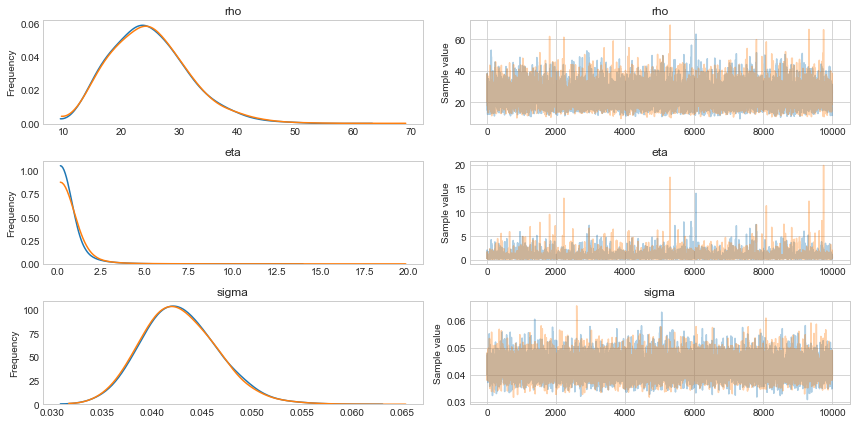

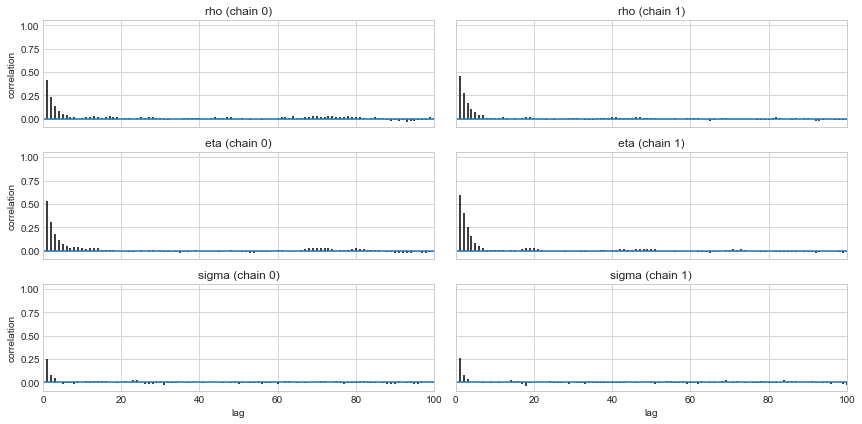

In [9]:
pm.traceplot(tr_gp)
pm.autocorrplot(tr_gp)
plt.tight_layout()

In [10]:
pm.gelman_rubin(tr_gp)

{'eta': 1.000340949352933,
 'rho': 1.0000811385991284,
 'sigma': 1.000076481794691}

In [11]:
# age_pred = (age_test - age_test.mean()).reshape(-1, 1)
age_pred = age_test.reshape(-1, 1)
with gp:
    p_gp_pred = p_gp.conditional('GP_pred', age_pred, pred_noise=True)
    p_gp_samples = pm.sample_ppc(tr_gp, model=gp, vars=[p_gp_pred], samples=10000)

100%|██████████| 10000/10000 [01:32<00:00, 107.20it/s]


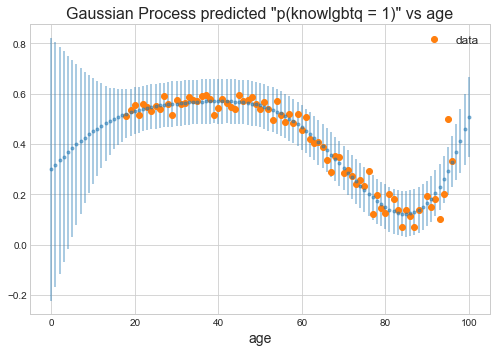

In [12]:
m = p_gp_samples['GP_pred'].mean(axis=0)
s = p_gp_samples['GP_pred'].std(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.errorbar(x=age_test, y=m, yerr=2*s, linestyle='', marker='.', alpha=0.5)
ax.plot(df_survey['age'], df_survey['p'], 'o', label='data')
ax.set_xlabel('age', fontsize=14)
ax.set_title('Gaussian Process predicted "p(knowlgbtq = 1)" vs age', fontsize=16)
ax.legend(fontsize=12)
plt.tight_layout()

### Answer 2.3
**How do the models compare? Does age influence likelihood of acquaintance with someone LGBTQ? For Bayesian Linear Regression and GP Regression, how does age affect the variance of the estimates?**

- How does age influence likelihood of acquaintance with someone LGBTQ?
> Both Bayesian linear regression and GP regression are able to model some dependency between age and the likelihood of knowing some LGBTQ. Bayesian linear regression modeled the linear negative correlation between the likelihood and age, while GP regression produced a non-linear (increase-decrease-increase) dependency. GP regression is more accurate as its predictions are closer to the observed data points than Bayesian linear regression. 

- Variance of estimates:
> Both models show larger variances at extreme age values (close to 0 or 100) because we don't observe data at extreme age ranges. The observed data points are better captured by GP model's 2-sigma envolope than by the Bayesian linear regression's.


<div class="answer-separator">
------------------------
</div>

## Question 3 - AM207 HWs Out (A OK I MIC DROP)!

**coding required**

In the dataset "reviews_processed.csv", you'll find a database of Yelp reviews for a number of restaurants. These reviews have already been processed and transformed by someone who has completed the (pre) modeling process described in Problem #1. That is, imagine the dataset in "reviews_processed.csv" is the result of feeding the raw Yelp reviews through the pipeline someone built for Problem #1.

The following is a full list of columns in the dataset and their meanings:

I. Relevant to 3.1-3.5:

  1. "review_id" - the unique identifier for each Yelp review
  2. "topic" - the subject addressed by the review (0 stands for food and 1 stands for service)
  3. "rid" - the unique identifier for each restaurant
  4. "count" - the number of sentences in a particular review on a particular topic
  5. "mean" - the probability of a sentence in a particular review on a particular topic being positive, averaged over total number of sentences in the review related to that topic.
  6. "var" - the variance of the probability of a sentence in a particular review on a particular topic being positive, taken over all sentences in the review related to that topic.

II. Relevant (possibly) to more complex models:

  1. "uavg" - the average star rating given by a particular reviewer (taken across all their reviews)
  2. "stars" - the number of stars given in a particular review
  3. "max" - the max probability of a sentence in a particular review on a particular topic being positive
  4. "min" - the min probability of a sentence in a particular review on a particular topic being positive

The following schema illustrates the model of the raw data that is used to generate "reviews_processed.csv":
<img src="restuarant_model.png">

***Warning:*** *this is a "real" data science problem in the sense that the dataset in "reviews_processed.csv" is large. We understand that a number of you have limited computing resources, so you are encouraged but not required to use the entire dataset. If you wish you may use 10 restaurants from the dataset, as long as your choice of 10 contains a couple of restaurants with a large number of reviews and a couple with a small number of reviews.*


When the value in "count" is low, the "mean" value can be very skewed.

3.1. Following the [SAT prep school example discussed in lab](https://am207.info/wiki/gelmanschoolstheory.html) (and influenced your answers for HW 10 Question #1), set up a Bayesian model (that is, write functions encapsulating the pymc3 code) for a reviewer $j$'s opinion of restaurant $k$'s food and service (considering the food and service separately).  You should have a model for each restaurant and each aspect being reviewed (food and serivce). For restaurant $k$, you will have a model for $\{\theta_{jk}^{\text{food}}\}$ and one for $\{\theta_{jk}^{\text{service}}\}$, where $\theta_{jk}$ is the positivity of the opinion of the $j$-th reviewer regarding the $k$-th restaurant. 

**Hint:** What quantity in our data naturally corresponds to $\bar{y}_j$'s in the prep school example? How would you calculate the parameter $\sigma_j^2$ in the distribution of $\bar{y}_j$ (note that, contrary to the school example, $\sigma_j^2$ is not provided explictly in the restaurant data)?

3.2. Just to test your that modeling makes sense choose 1 restaurant and run your model from 3.1 on the food and service aspects for that restaurant.  Create 10K samples  each for the food and service model for your chosen restuarant and visualize your samples via a traceplot for each aspect of the restaurant reviews.

3.3. Use your model from 3.1 to produce estimates for $\theta_{jk}$'s for multiple restaurants. Pick a few (try for 5 but if computer power is a problem, choose 2) restaurants and for each aspect ("food" and "service") of each restaurant, plot your estimates for the $\theta$'s against the values in the "mean" column (corresponding to this restaurant). 

For the chosen restaurants, for each aspect ("food" and "service"), generate shrinkage plots and probability shrinkage plots as follows:

**Shrinkage plot for a restaurant, topic**:

> The aim for this plot is to see the shrinkage from sample means (error bars generated from standard error) to $\theta_{jk}$'s (error bars generated from theta variance).  
>
> The sample means of reviews are plotted at $y=0$ and the posterior means ($\theta_{ik}$) are plotted at $y=1$. For each review connect the sample mean to the posterior mean with a line.  Show error bars on the sample mean points using standard error and on the ($\theta_{jk}$) points using variance.

**Probability Shrinkage plot for a restaurant, topic**:

> The aim for this plot is to see the shrinkage from the classification probabilities from the sample means of reviews to the classification probabilities of $\theta_{jk}$'s.  The classification probabilities are calculated from the gaussian at the given mean and variance. The sample means and standard error are fed into the gaussian to generate one set of classification probabilities.  The $\theta_{jk}$ estimates and variances are fed into the gaussian to generate the other set of variances.
>
> The y values are the classification probability (calculated as 1-cdf) using the normal distribution at a given mean and variance.
>
> The sample means of reviews are plotted with $y$'s obtained by using the sample means as the means in the normal above, with line segments (error bars) representing the standard error. 
>
> The posterior means ($\theta_{jk}$) are plotted with $y$'s obtained using the posterior means (thetas) in the gaussian above, and variances on the thetas with line segments (error bars) representing the variances on the $\theta_{jk}$'s.
>
>We've provided you some code to generate a shrinkage plot and a probability shrinkage plot is included in this notebook, but feel free to implement your own. The code should also help elucidate the text above.

Example of a shrinkage plot:
<img src="https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9gx9xfww9%2Fshrinkage.png" width="400" height="400"/>

Example of a probability shrinkage plot:
<img src="https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9fsbbu9bs%2Fshrinkage_prob.png" width="400" height="400"/>


3.4. Based on your shrinkage plots and probability shrinkage plots in 3.3 discuss the statistical benefits of modeling each reviewer's opinion using your hierarchical model rather than approximating the reviewer opinion with the value in "mean".

3.5. Aggregate, in a simple but reasonable way, the reviewer's opinions given a pair of overall scores for each restaurant -- one for food and one for service. Rank the restaurants by food score and then by service score. 

(**Hint:**  Think what an average score for each aspect would do here?)

3.6. Discuss the statistical weakness of ranking by these scores.

(**Hint:** What is statistically problematic about the way you aggregated the reviews of each restaurant to produce an overall food or service score? This is also the same problem with summarizing a reviewer's opinion on a restaurants service and food based on what they write.)  


In [2]:
import itertools

# Use 1-cdf at 0.5 to model the probability of having positive sentiment
# it basically tells you the area under the gaussian after 0.5 (we'll assume 
# positive sentiment based on the usual probability > 0.5 criterion)

prob = lambda mu, vari: .5 * (1 - erf((0.5- mu) / np.sqrt(2 * vari)))

# fix a restaurant and an aspect (food or service)
# "means" is the array of values in the "mean" column for the restaurant and the aspect 
#         in the dataset
# "thetas" is the array of values representing your estimate of the opinions of reviewers 
#          regarding this aspect of this particular restaurant
# "theta_vars" is the array of values of the varaiances of the thetas
# "counts" is the array of values in the "count" column for the restaurant and the aspect 
#.         in the dataset
# FEEL FREE TO RE-IMPLEMENT THESE

def shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=0) shrink to
    review $theta$s, plotted at y=1
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)   
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, thetax error, count
            color=next(palette)
            # add some jitter to y values to separate them
            noise=0.04*np.random.randn()
            noise2=0.04*np.random.randn()
            if me==0:
                me = 4
            # plot shrinkage line from mean, 0 to
            # theta, 1. Also plot error bars
            ax.plot([m,t],[noise,1+noise2],'o-', color=color, lw=1)
            ax.errorbar([m,t],[noise,1+noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color,  lw=1)
        ax.set_yticks([])
        ax.set_xlim([0,1])
        sns.despine(offset=-2, trim=True, left=True)
    return ax

def prob_shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=prob(mean)) shrink to
    review $theta$s, plotted at y=prob(theta)
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, theta error, count
            color = next(palette)
            # add some jitter to y values to separate them
            noise = 0.001 * np.random.randn()
            noise2 = 0.001 * np.random.randn()
            if me == 0: #make mean error super large if estimated as 0 due to count=1
                me = 4
            p = prob(m, me)
            peb = prob(t, te)
            # plot shrinkage line from mean, prob-based_on-mean to
            # theta, prob-based_on-theta. Also plot error bars
            ax.plot([m, t],[p, peb],'o-', color=color, lw=1)
            ax.errorbar([m, t],[p + noise, peb + noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color, lw=1)
        ax = plt.gca()
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
    return ax

**Gratuitous Titular Reference**:  

Thank you for putting up with us -- No more HWs!  No more gratuitous titular references!

We'll leave with a [Steve Aoki](http://www.steveaoki.com/) and [K-Pop](https://en.wikipedia.org/wiki/K-pop) style [Mic Drop](https://www.youtube.com/watch?v=kTlv5_Bs8aw).  Take it away [BTS](https://en.wikipedia.org/wiki/BTS_(band)).  Don't [Burn the Stage](https://www.youtube.com/watch?v=uwgDg8YnU8U) on the way out!

[AM207 HW Crew out!](https://www.youtube.com/watch?v=Tg0hLMop200)

### Answer 3.1

We build 1 model for each restaurant given a review topic (i.e. food or service)

- $y_{ijk}$: the positivity in the i-th sentence in the j-th review for the k-th restaurant. (Not observed.)
- $\bar{y_{jk}} = \sum_i^{n_{jk}} y_{ijk}$: sample mean positivity of a total of $n_{jk}$ sentences in the j-th review for the k-th restaurant. ("mean" column in the observed data)
- $\theta_{jk}$: parametric sample mean of the k-th restaurant's j-th review's mean postitivity (Modeled by the posterior draws)
- $\sigma_{jk}$: sample variance of of the k-th restaurant's j-th review's mean postitivity. ($\sqrt{\text{"var"/"count"}}$ computed from the observed data)

$$
\begin{align}
\mu_k &\sim \mathcal{N}(0.5, 0.2) \\
\tau_k &\sim \text{Half-Cauchy}(0, 0.2) \\
\nu_{jk} &\sim \mathcal{N}(0, 0.5) \\
\theta_{jk} &= \mu_k + \tau_k \nu_{jk} \\
\bar{y_{jk}} &\sim \mathcal{N}(\theta_{jk}, \sigma_{jk}) \\
\end{align}
$$
<br>

**Note:** We chose $\mu \sim \mathcal{N}(0.5, 0.2)$, $\tau_k \sim \text{Half-Cauchy}(0, 0.2)$ and $\nu_{jk} \sim \mathcal{N}(0, 0.5)$  as we observe the aggregated mean and standard deviation of the `mean` column values for each restaurant are around mean = 0.5, sd = 0.1 (see below: `df_agg`)


In [3]:
# 3.1 modeling
# load all reviews
df_review = pd.read_csv('reviews_processed.csv')
print('# restaurants = {}'.format(df_review['rid'].nunique()))
print('# review_ids = {}'.format(df_review['review_id'].nunique()))
print('raw data shape: ', df_review.shape)

# restaurants = 11417
# review_ids = 88972
raw data shape:  (147914, 10)


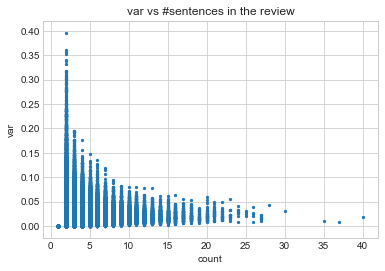

In [4]:
# visualize `var`
plt.scatter(df_review['count'], df_review['var'], s=5)
plt.title('var vs #sentences in the review')
plt.xlabel('count')
plt.ylabel('var')
plt.show()

**The 1-sentence reviews have 0 variance. As our model models sample variance of the `mean` column values, these 1-sentence reviews should be dropped.**

In [5]:
df_review = df_review[df_review['count'] > 1]
print('After dropping 1-sentence reviews (cannot compute sample variance), data shape:', df_review.shape)

After dropping 1-sentence reviews (cannot compute sample variance), data shape: (105576, 10)


In [6]:
# compute sample std
df_review['sd'] = np.sqrt(df_review['var'] / df_review['count'])

# separate reviews focused on 'food' vs 'service'
df_food = df_review[df_review['topic']==0]
df_service = df_review[df_review['topic']==1]
print('# food reviews = {}, # service reviews = {}'.format(df_food.shape[0], df_service.shape[0]))

display(df_food.head())
display(df_service.head())

# food reviews = 62801, # service reviews = 42775


,review_id,topic,rid,count,max,mean,min,stars,uavg,var,sd
0,---sV8KdwfBoDw38KW_WnQ,0,VgLiSW1iGkpzIEXOgvUBEw,5,0.689383,0.558430,0.312919,3,3.285714,0.024112,0.069444
2,--0MzHNy7MVBRvZCOAeRPg,0,4gLecengX1JeGILm7DwU3w,3,0.746711,0.574416,0.360240,5,3.829268,0.038655,0.113513
4,--2NT40xmHh9oBLumzdjhA,0,4ZZab5hinFzHtj3sE8vQWg,5,0.764218,0.601008,0.337710,2,4.181818,0.026742,0.073133
6,--2Ylq1M_Toj6e0hy_C2XA,0,e9er1p-8RMyRa9IKUzKE-w,4,0.743135,0.613059,0.539191,4,3.500000,0.008469,0.046013
8,--3QRshg8GhfimzyGWkcAQ,0,T2zItRCqolfzSZR2Io0OZg,2,0.758943,0.756603,0.754264,5,3.250000,0.000011,0.002340


,review_id,topic,rid,count,max,mean,min,stars,uavg,var,sd
1,---sV8KdwfBoDw38KW_WnQ,1,VgLiSW1iGkpzIEXOgvUBEw,5,0.816901,0.554300,0.211441,3,3.285714,0.050309,0.100308
3,--0MzHNy7MVBRvZCOAeRPg,1,4gLecengX1JeGILm7DwU3w,6,0.848065,0.657755,0.476156,5,3.829268,0.014583,0.049300
5,--2NT40xmHh9oBLumzdjhA,1,4ZZab5hinFzHtj3sE8vQWg,4,0.630715,0.467825,0.386750,2,4.181818,0.012157,0.055128
11,--4Z-DXhanD-sXyLFnNTbQ,1,abyw7M9utpZJGo_RF0LScQ,2,0.918739,0.812584,0.706429,4,3.625000,0.022538,0.106155
15,--6fCn5V-92CSojgIpHOpA,1,ufOY2lQHDgSvou3YLT8gHA,8,0.764067,0.566308,0.356958,4,4.500000,0.025397,0.056344


In [7]:
# aggregate review scores by restaurant - statistics of sample means
df_food_agg = df_food.groupby(['rid'])['mean'].agg([len, 'mean', 'std']).sort_values('len', ascending=False)
df_service_agg = df_service.groupby(['rid'])['mean'].agg([len, 'mean', 'std']).sort_values('len', ascending=False)
df_agg = df_food_agg.join(df_service_agg, lsuffix='_f', rsuffix='_s')
df_agg['total_reviews'] = df_agg['len_f'] + df_agg['len_s']
df_agg.sort_values('total_reviews', ascending=False, inplace=True)
df_agg.head(20)

,len_f,mean_f,std_f,len_s,mean_s,std_s,total_reviews
rid,,,,,,,
fQYh3SW_QEL1uSB23x1rnA,8.0,0.648269,0.082843,8.0,0.604662,0.157165,16.0
_Q4VSHSr8ryAOfmsd9g6yA,8.0,0.580300,0.073060,8.0,0.589476,0.148721,16.0
P5nqpZIxAhkBxCLaYwyaig,8.0,0.516006,0.174115,8.0,0.506065,0.107119,16.0
uFi6gZIorIy9WGkCxnGrdQ,8.0,0.554452,0.065287,8.0,0.567770,0.111211,16.0
7lFWEsNkTR0RwI4Dvhueww,8.0,0.649702,0.077089,8.0,0.670058,0.030180,16.0
-6ozQS5Mc6xDyGFNLNh7ZA,8.0,0.661272,0.088145,8.0,0.682407,0.128940,16.0
ChmqODwuYP1ewjmWXtxtsg,8.0,0.611089,0.056165,8.0,0.679755,0.062477,16.0
vWnKq70W_WZ7FFLgmAfv9A,8.0,0.657165,0.114014,8.0,0.677089,0.081725,16.0
C4GHQTB-G0R2Geov298GLw,8.0,0.718082,0.068644,8.0,0.743338,0.086329,16.0


In [8]:
# 3.2 model for 1 restaurant
rid_1 = 'fQYh3SW_QEL1uSB23x1rnA'
print('--- restaurant: {} ---'.format(rid_1))
f_agg_len, f_agg_mean, f_agg_sd = df_food_agg.loc[rid_1]
s_agg_len, s_agg_mean, s_agg_sd = df_service_agg.loc[rid_1]

# subset reviews for food & service for the selected restaurant
df_food_1 = df_food[df_food['rid'] == rid_1]
df_service_1 = df_service[df_service['rid'] == rid_1]
print('# food reviews = {}, mean of sample mean = {}, sd of sample mean = {}'.format(
    int(f_agg_len), f_agg_mean, f_agg_sd))
print('# service reviews = {}, mean of sample mean = {}, sd of sample mean = {}'.format(
    int(s_agg_len), s_agg_mean, s_agg_sd))

--- restaurant: fQYh3SW_QEL1uSB23x1rnA ---
# food reviews = 8, mean of sample mean = 0.64826895879575, sd of sample mean = 0.0828426747449958
# service reviews = 8, mean of sample mean = 0.6046618666248751, sd of sample mean = 0.15716513877904


In [9]:
with Model() as food_1:
    mu = pm.Normal('mu', mu=0.5, sd=0.2)
    tau = pm.HalfCauchy('tau', beta=0.2)
    nu = pm.Normal('nu', mu=0, sd=0.5, shape=int(f_agg_len))
    theta = pm.Deterministic('theta', mu + tau * nu)
    Y = pm.Normal('Y', mu=theta, sd=df_food_1['sd'], observed=df_food_1['mean'])
    tr_food_1 = pm.sample(10000, tune=2000, nuts_kwargs={'target_accept':0.99})

with Model() as service_1:    
    mu = pm.Normal('mu', mu=0.5, sd=0.2)
    tau = pm.HalfCauchy('tau', beta=0.2)
    nu = pm.Normal('nu', mu=0, sd=0.5, shape=int(s_agg_len))
    theta = pm.Deterministic('theta', mu + tau * nu)
    Y = pm.Normal('Y', mu=theta, sd=df_service_1['sd'], observed=df_service_1['mean'])
    tr_service_1 = pm.sample(10000, tune=2000, nuts_kwargs={'target_accept':0.99})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau, mu]
Sampling 2 chains: 100%|██████████| 24000/24000 [02:13<00:00, 180.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau, mu]
Sampling 2 chains: 100%|██████████| 24000/24000 [01:35<00:00, 252.19draws/s]


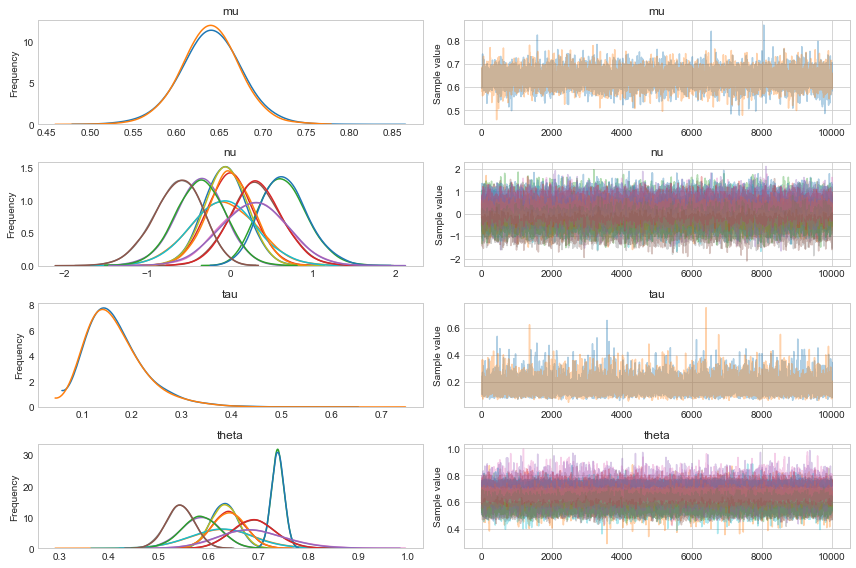

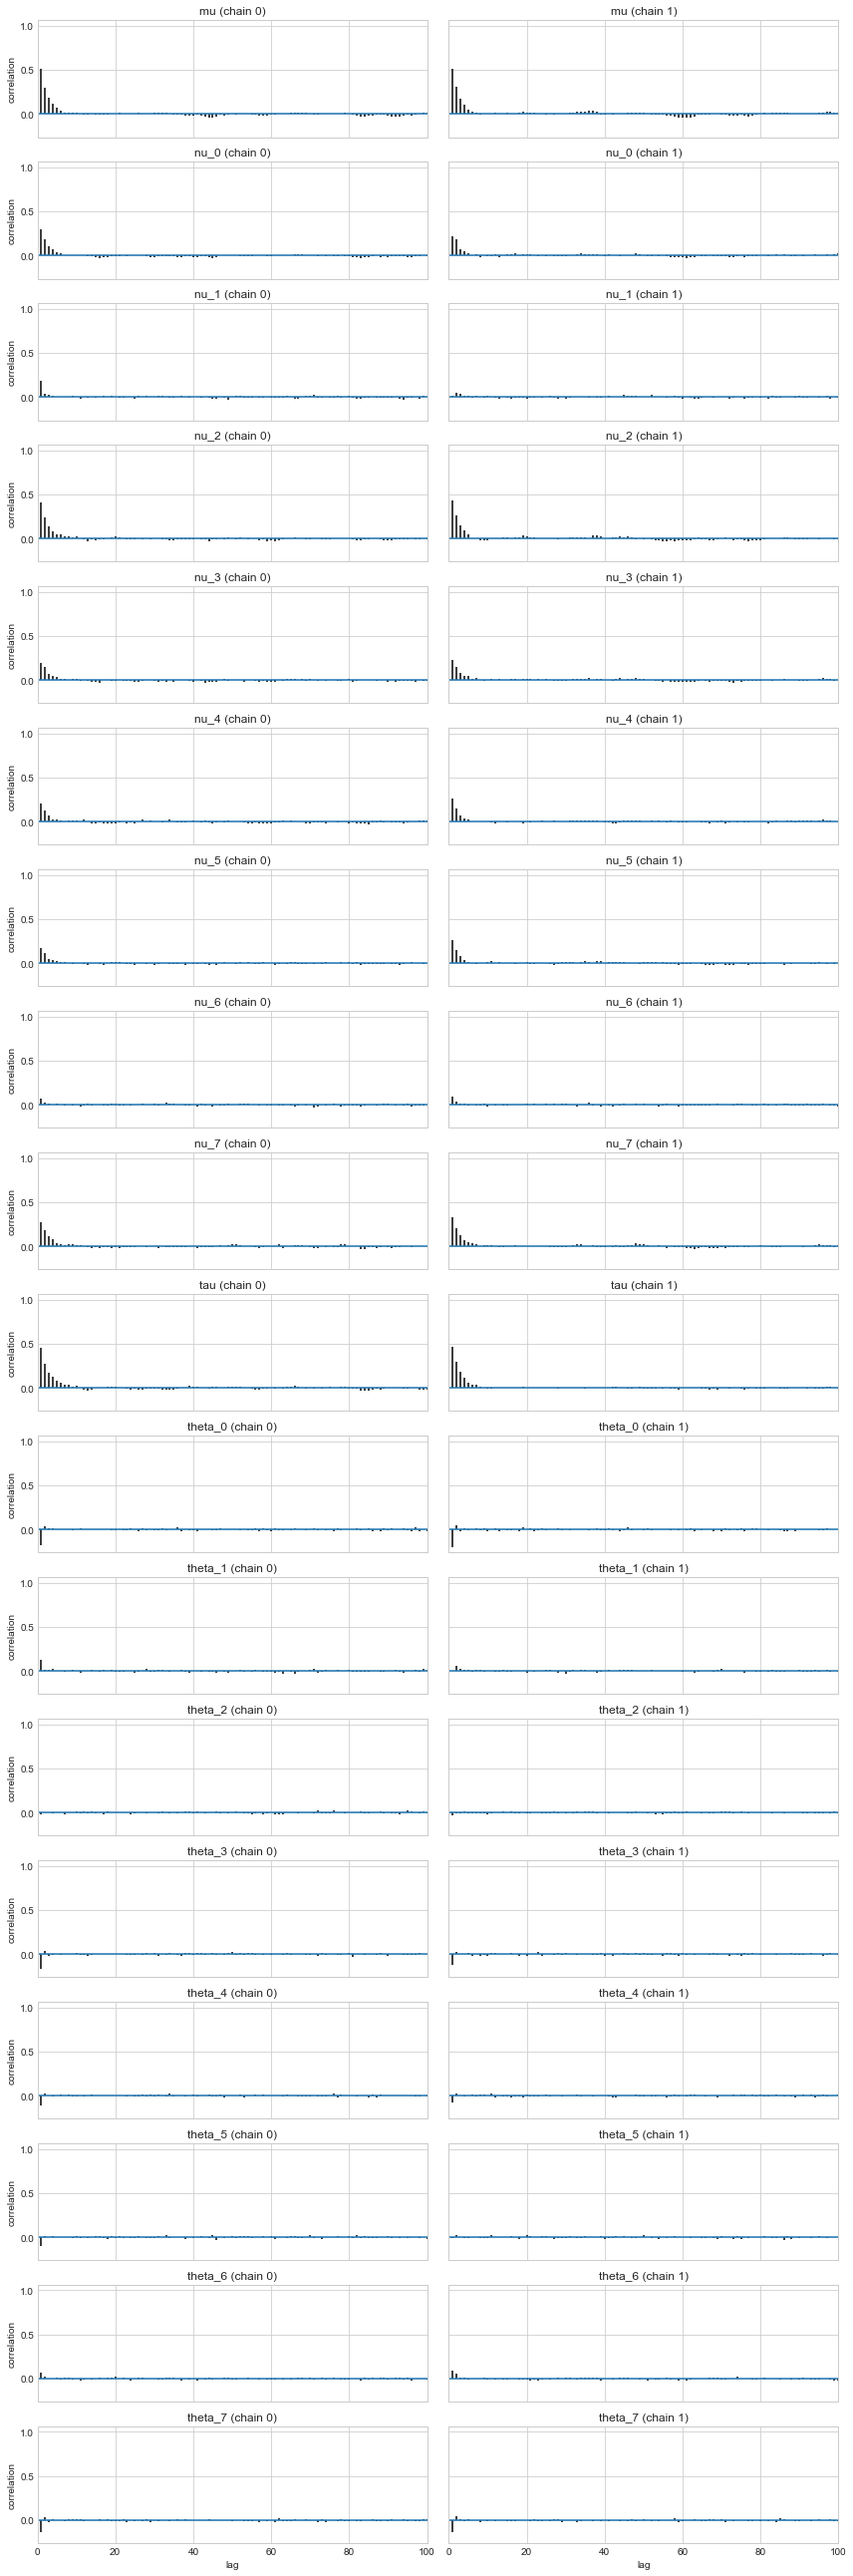

In [12]:
pm.traceplot(tr_food_1)
pm.autocorrplot(tr_food_1)
plt.tight_layout()

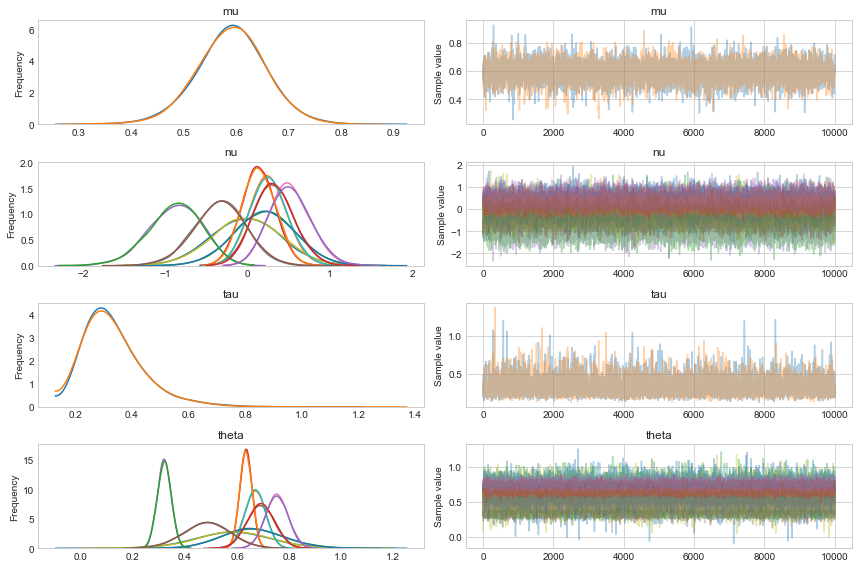

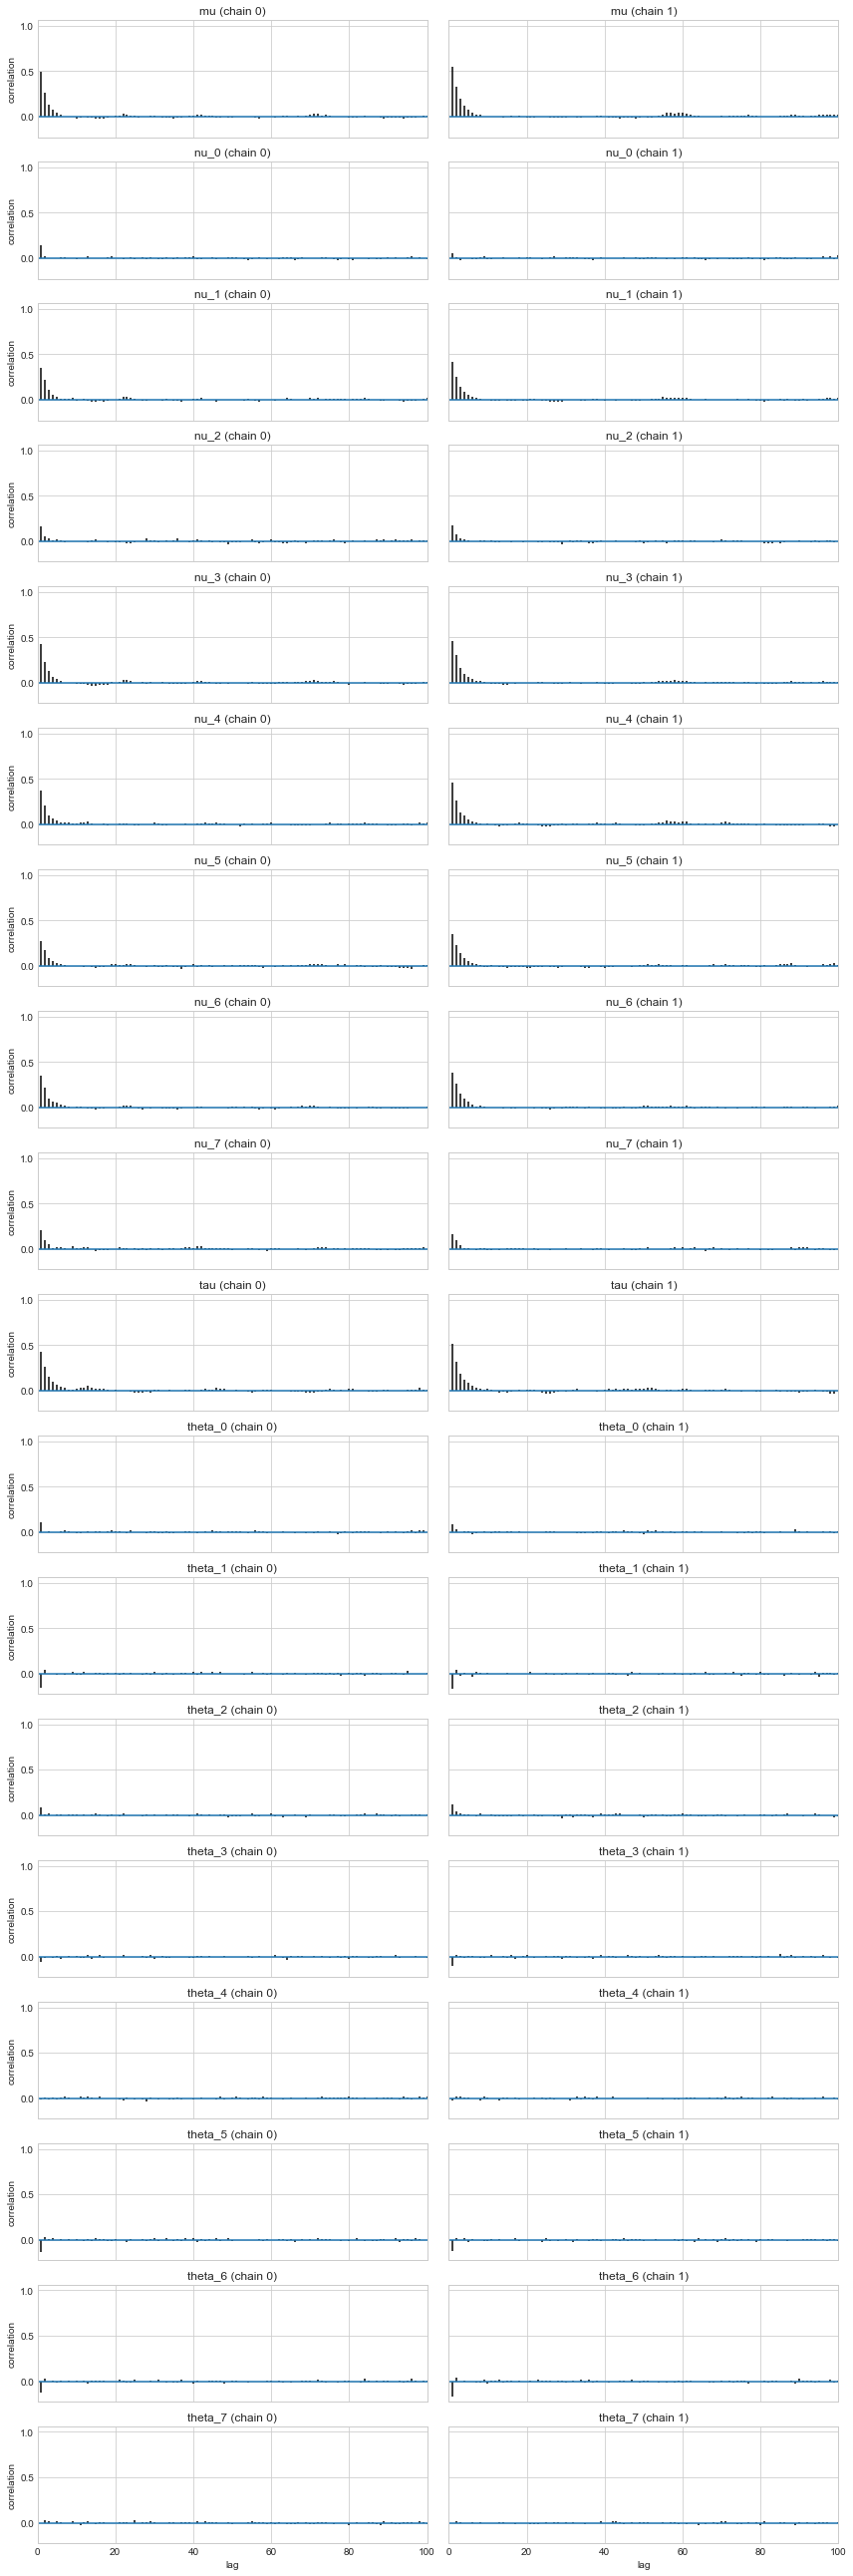

In [13]:
pm.traceplot(tr_service_1)
pm.autocorrplot(tr_service_1)
plt.tight_layout()

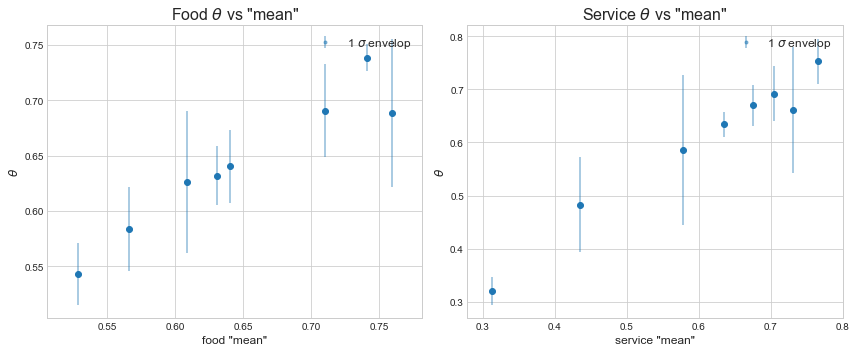

In [14]:
# plot theta against 'mean'
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(df_food_1['mean'], tr_food_1['theta'].mean(axis=0))
ax[1].scatter(df_service_1['mean'], tr_service_1['theta'].mean(axis=0))

ax[0].errorbar(x=df_food_1['mean'], y=tr_food_1['theta'].mean(axis=0), yerr=tr_food_1['theta'].std(axis=0), 
               linestyle='', marker='.', alpha=0.5, label=r'1 $\sigma$ envelop')
ax[1].errorbar(x=df_service_1['mean'], y=tr_service_1['theta'].mean(axis=0), yerr=tr_service_1['theta'].std(axis=0), 
               linestyle='', marker='.', alpha=0.5, label=r'1 $\sigma$ envelop')
ax[0].set_title(r'Food $\theta$ vs "mean"', fontsize=16)
ax[1].set_title(r'Service $\theta$ vs "mean"', fontsize=16)
ax[0].set_xlabel('food "mean"', fontsize=12)
ax[1].set_xlabel('service "mean"', fontsize=12)
ax[0].set_ylabel(r'$\theta$', fontsize=12)
ax[1].set_ylabel(r'$\theta$', fontsize=12)
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
plt.tight_layout()

In [15]:
# 3.5 model for 5 restaurant 
rids_5 = [
    'fQYh3SW_QEL1uSB23x1rnA',
    '_Q4VSHSr8ryAOfmsd9g6yA',
    'uFi6gZIorIy9WGkCxnGrdQ',
    'ChmqODwuYP1ewjmWXtxtsg',
    'C4GHQTB-G0R2Geov298GLw'
]

In [16]:
traces = {'food':{}, 'service':{}}
models = {'food':{}, 'service':{}}
traces['food'][rid_1] = tr_food_1
traces['service'][rid_1] = tr_service_1
models['food'][rid_1] = food_1
models['service'][rid_1] = service_1

for i, rid in enumerate(rids_5[1:]):
    print('--- restaurant: {} ---'.format(rid))
    f_agg_len, f_agg_mean, f_agg_sd = df_food_agg.loc[rid]
    s_agg_len, s_agg_mean, s_agg_sd = df_service_agg.loc[rid]
    
    # subset reviews for food & service for the selected restaurant
    df_food_rid = df_food[df_food['rid'] == rid]
    df_service_rid = df_service[df_service['rid'] == rid]
    print('# food reviews = {}, mean of sample mean = {}, sd of sample mean = {}'.format(
        int(f_agg_len), f_agg_mean, f_agg_sd))
    print('# service reviews = {}, mean of sample mean = {}, sd of sample mean = {}'.format(
        int(s_agg_len), s_agg_mean, s_agg_sd))

    with Model() as model_food:
        mu = pm.Normal('mu', mu=0.5, sd=0.2)
        tau = pm.HalfCauchy('tau', beta=0.2)
        nu = pm.Normal('nu', mu=0, sd=0.5, shape=int(f_agg_len))
        theta = pm.Deterministic('theta', mu + tau * nu)
        Y = pm.Normal('Y', mu=theta, sd=df_food_rid['sd'], observed=df_food_rid['mean'])
        tr_food = pm.sample(10000, tune=2000, nuts_kwargs={'target_accept':0.99})

    with Model() as model_service:    
        mu = pm.Normal('mu', mu=0.5, sd=0.2)
        tau = pm.HalfCauchy('tau', beta=0.2)
        nu = pm.Normal('nu', mu=0, sd=0.5, shape=int(s_agg_len))
        theta = pm.Deterministic('theta', mu + tau * nu)
        Y = pm.Normal('Y', mu=theta, sd=df_service_rid['sd'], observed=df_service_rid['mean'])
        tr_service = pm.sample(10000, tune=2000, nuts_kwargs={'target_accept':0.99})
    
    traces['food'][rid] = tr_food
    traces['service'][rid] = tr_service
    models['food'][rid] = model_food
    models['service'][rid] = model_service

--- restaurant: _Q4VSHSr8ryAOfmsd9g6yA ---
# food reviews = 8, mean of sample mean = 0.58029955955675, sd of sample mean = 0.0730602374994519
# service reviews = 8, mean of sample mean = 0.5894755729195, sd of sample mean = 0.14872117312871408


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau, mu]
Sampling 2 chains: 100%|██████████| 24000/24000 [01:01<00:00, 390.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau, mu]
Sampling 2 chains: 100%|██████████| 24000/24000 [01:00<00:00, 398.03draws/s]


--- restaurant: uFi6gZIorIy9WGkCxnGrdQ ---
# food reviews = 8, mean of sample mean = 0.554452189632125, sd of sample mean = 0.06528654448505176
# service reviews = 8, mean of sample mean = 0.5677697759441249, sd of sample mean = 0.1112107820772069


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau, mu]
Sampling 2 chains: 100%|██████████| 24000/24000 [01:01<00:00, 390.20draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau, mu]
Sampling 2 chains: 100%|██████████| 24000/24000 [01:19<00:00, 303.54draws/s]


--- restaurant: ChmqODwuYP1ewjmWXtxtsg ---
# food reviews = 8, mean of sample mean = 0.611089302011125, sd of sample mean = 0.056164626541767244
# service reviews = 8, mean of sample mean = 0.67975485360925, sd of sample mean = 0.06247654163337416


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau, mu]
Sampling 2 chains: 100%|██████████| 24000/24000 [01:09<00:00, 343.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau, mu]
Sampling 2 chains: 100%|██████████| 24000/24000 [01:53<00:00, 189.85draws/s]


--- restaurant: C4GHQTB-G0R2Geov298GLw ---
# food reviews = 8, mean of sample mean = 0.7180823245118749, sd of sample mean = 0.06864391095108872
# service reviews = 8, mean of sample mean = 0.7433380019913749, sd of sample mean = 0.08632933883811969


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau, mu]
Sampling 2 chains: 100%|██████████| 24000/24000 [01:01<00:00, 391.51draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau, mu]
Sampling 2 chains: 100%|██████████| 24000/24000 [00:52<00:00, 453.35draws/s]


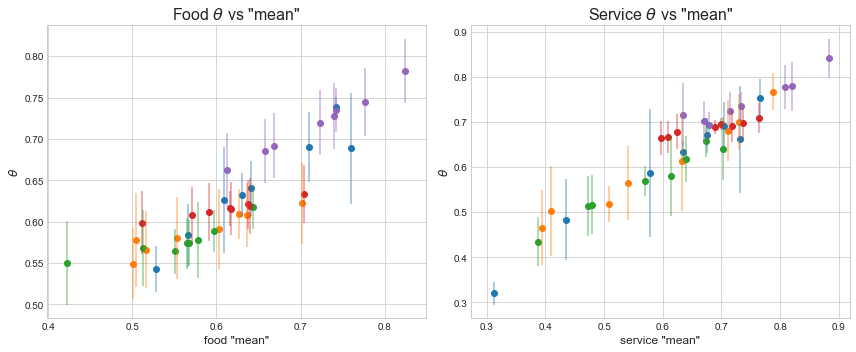

In [18]:
# plot theta against 'mean'
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, rid in enumerate(rids_5):
    tr_food = traces['food'][rid]
    tr_service = traces['service'][rid]
    food_mean = df_food[df_food['rid'] == rid]['mean']
    service_mean = df_service[df_service['rid'] == rid]['mean']
    
    ax[0].scatter(food_mean, tr_food['theta'].mean(axis=0))
    ax[1].scatter(service_mean, tr_service['theta'].mean(axis=0))

    ax[0].errorbar(x=food_mean, y=tr_food['theta'].mean(axis=0), yerr=tr_food['theta'].std(axis=0), 
                   linestyle='', marker='.', alpha=0.5)
    ax[1].errorbar(x=service_mean, y=tr_service['theta'].mean(axis=0), yerr=tr_service['theta'].std(axis=0), 
                   linestyle='', marker='.', alpha=0.5)

ax[0].set_title(r'Food $\theta$ vs "mean"', fontsize=16)
ax[1].set_title(r'Service $\theta$ vs "mean"', fontsize=16)
ax[0].set_xlabel('food "mean"', fontsize=12)
ax[1].set_xlabel('service "mean"', fontsize=12)
ax[0].set_ylabel(r'$\theta$', fontsize=12)
ax[1].set_ylabel(r'$\theta$', fontsize=12)

plt.tight_layout()

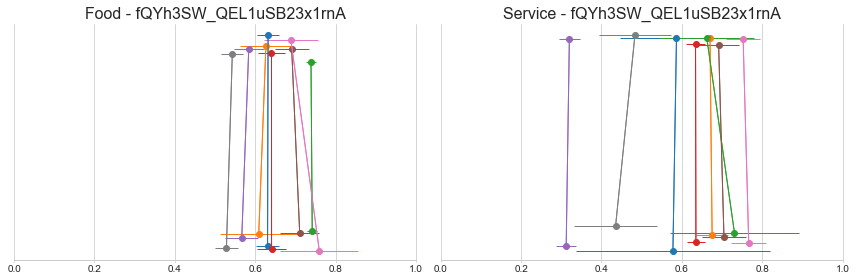

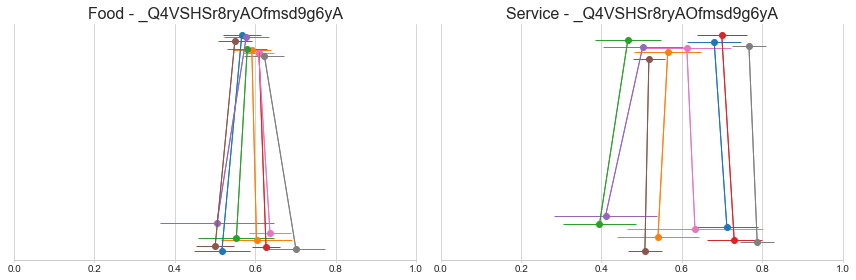

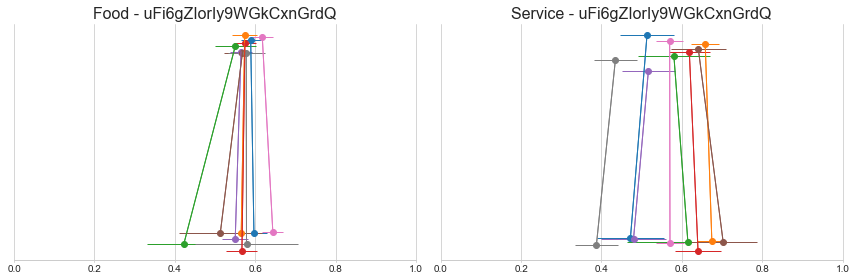

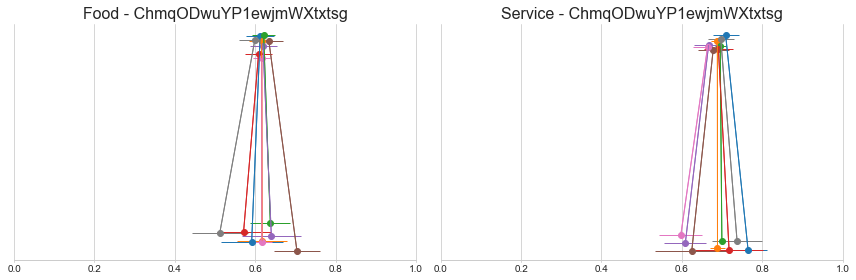

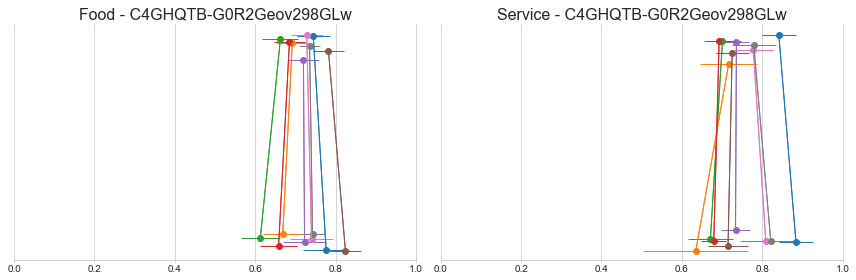

In [19]:
for i, rid in enumerate(rids_5):
    # data observed
    df_food_rid = df_food[df_food['rid'] == rid]
    df_service_rid = df_service[df_service['rid'] == rid]
    
    f_mean = df_food_rid['mean']
    f_var = df_food_rid['var']
    f_count = df_food_rid['count']
    
    s_mean = df_service_rid['mean']
    s_var = df_service_rid['var']
    s_count = df_service_rid['count']
    
    # fitted thetas
    f_thetas= traces['food'][rid]['theta']
    s_thetas = traces['service'][rid]['theta']
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0] = shrinkage_plot(f_mean, f_thetas.mean(0), f_var, f_thetas.var(0), f_count, ax[0])
    ax[1] = shrinkage_plot(s_mean, s_thetas.mean(0), s_var, s_thetas.var(0), s_count, ax[1])
    ax[0].set_title('Food - {}'.format(rid), fontsize=16)
    ax[1].set_title('Service - {}'.format(rid), fontsize=16)
    plt.tight_layout()

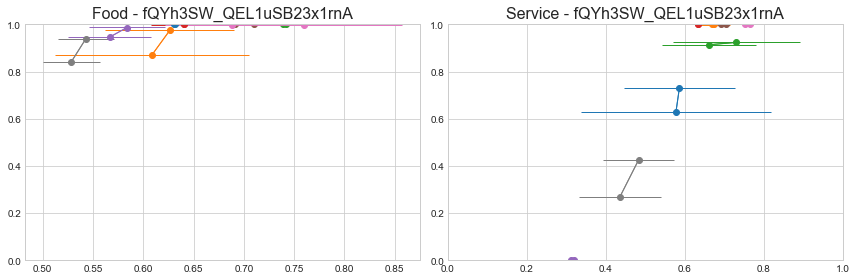

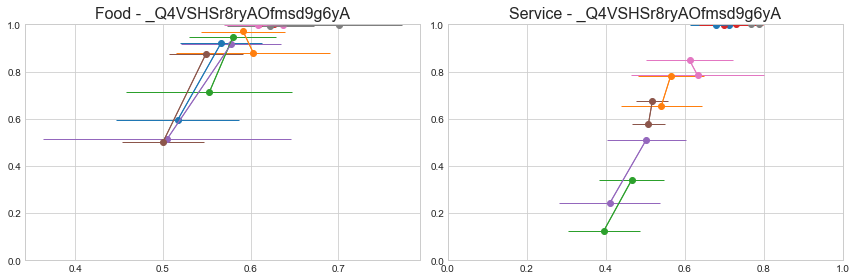

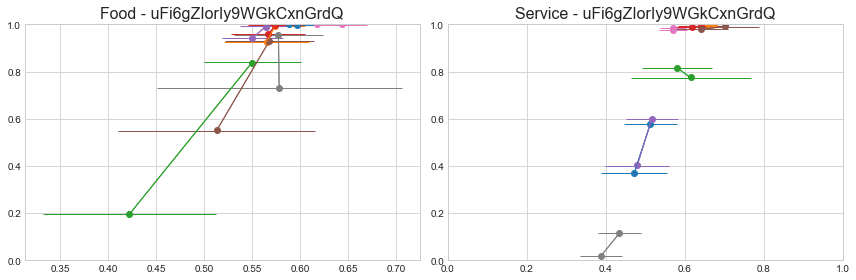

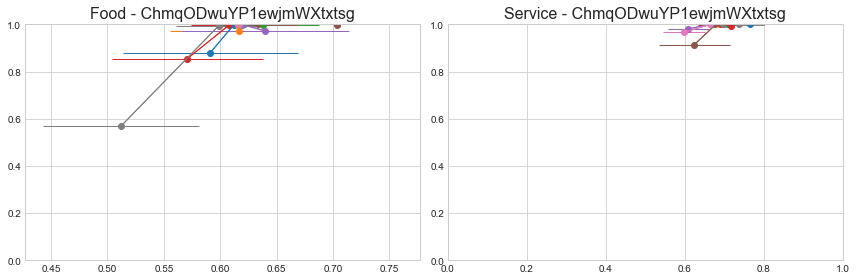

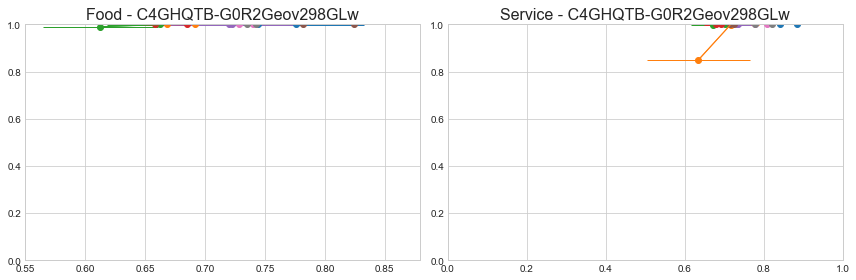

In [20]:
for i, rid in enumerate(rids_5):
    # data observed
    df_food_rid = df_food[df_food['rid'] == rid]
    df_service_rid = df_service[df_service['rid'] == rid]
    
    f_mean = df_food_rid['mean']
    f_var = df_food_rid['var']
    f_count = df_food_rid['count']
    
    s_mean = df_service_rid['mean']
    s_var = df_service_rid['var']
    s_count = df_service_rid['count']
    
    # fitted thetas
    f_thetas= traces['food'][rid]['theta']
    s_thetas = traces['service'][rid]['theta']
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    prob_shrinkage_plot(f_mean, f_thetas.mean(0), f_var, f_thetas.var(0), f_count, ax[0])
    prob_shrinkage_plot(s_mean, s_thetas.mean(0), s_var, s_thetas.var(0), s_count, ax[1])
    ax[0].set_title('Food - {}'.format(rid), fontsize=16)
    ax[1].set_title('Service - {}'.format(rid), fontsize=16)
    ax[0].set_ylim(0, 1)
    ax[1].set_ylim(0, 1)
    plt.tight_layout()

### Answer 3.4
**Based on your shrinkage plots and probability shrinkage plots in 3.3 discuss the statistical benefits of modeling each reviewer's opinion using your hierarchical model rather than approximating the reviewer opinion with the value in "mean".**

In general, both the shrinkage plots and the probability shrinkage plots show a reduced variance in the $\theta$ compared to the raw variance of "mean" positivity in each review. This indicates that high-variance (low-confidence) in some reviews can be reduced (improved) by using the hierarchical modeling to borrow statistial strength from other low-variance (high-confidence) reviews of the same restaurant.

---

In [21]:
# 3.5 aggregate food & service scores
mean_f_thetas = []
mean_s_thetas = []
for i, rid in enumerate(rids_5):
    f_thetas= traces['food'][rid]['theta']
    s_thetas = traces['service'][rid]['theta']
    mean_f_thetas.append(f_thetas.mean(0).mean())
    mean_s_thetas.append(s_thetas.mean(0).mean())

df_subset = pd.DataFrame(data={
    'mean_f_theta': mean_f_thetas,
    'mean_s_theta': mean_s_thetas
}, index=rids_5)
df_subset['mean_theta'] = df_subset[['mean_f_theta', 'mean_s_theta']].mean(axis=1)

df_subset.join(df_agg).sort_values(['mean_f_theta', 'mean_s_theta'], ascending=False)

,mean_f_theta,mean_s_theta,mean_theta,len_f,mean_f,std_f,len_s,mean_s,std_s,total_reviews
C4GHQTB-G0R2Geov298GLw,0.718632,0.746095,0.732363,8.0,0.718082,0.068644,8.0,0.743338,0.086329,16.0
fQYh3SW_QEL1uSB23x1rnA,0.642921,0.599963,0.621442,8.0,0.648269,0.082843,8.0,0.604662,0.157165,16.0
ChmqODwuYP1ewjmWXtxtsg,0.615602,0.686091,0.650846,8.0,0.611089,0.056165,8.0,0.679755,0.062477,16.0
_Q4VSHSr8ryAOfmsd9g6yA,0.588134,0.601246,0.594690,8.0,0.580300,0.073060,8.0,0.589476,0.148721,16.0
uFi6gZIorIy9WGkCxnGrdQ,0.576766,0.566508,0.571637,8.0,0.554452,0.065287,8.0,0.567770,0.111211,16.0


### Answer 3.6

**Statistical weakness of ranking by these scores**

(**Hint:** What is statistically problematic about the way you aggregated the reviews of each restaurant to produce an overall food or service score? This is also the same problem with summarizing a reviewer's opinion on a restaurants service and food based on what they write.)  

- By aggregating the review scores into 1 value, we lose the information about the topic/focus of that review.

- Quantifying positivity based on what people write in the reviews is subjective. 

- Different users have different *priors* for reviews, i.e. "amazing" means different things for different people. 


<div class="answer-separator">
------------------------
</div>